# Draw your own geophysics (map2tomofast)

Example notebook that extracts profiles and areas from Australia-wide grav & mag datasets, togetehr with local petrophysics data, dtm profile and geological profile.

Very slow to access data at the moment, will look into ways of speeding up this part of process.

Requires GA geophys_utils code and map2loop-2 code

#### questions:

1) what do do about zero mag sus values zero = 0 or NULL?   
2) what distance matters for local?   
3) is 3 local better than 25 regional?  
4) include GCS/GZF/GTK etc ?   

#### todo
1) remove hardwired field names   
2) make all paths remote   
3) fix no petrophsyics text   


In [2]:
import os
import netCDF4
import numpy as np
from geophys_utils import NetCDFGridUtils
from geophys_utils import get_netcdf_edge_points, points2convex_hull
import matplotlib.pyplot as plt
import time
import map2loop.SpaceTime as st
import map2loop.Geophysics as geophys
from math import sqrt, pi
%matplotlib inline

In [3]:
max_bytes = 500000000

netcdf_path = "https://dapds00.nci.org.au/thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Gravmap2019/Gravmap2019-grid-grv_cscba.nc"
netcdf_dataset = netCDF4.Dataset(netcdf_path, 'r')

netcdf_path_mag ="https://dapds00.nci.org.au/thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Magmap2019/Magmap2019-grid-tmi-Cellsize40m-AWAGS_MAG_2019.nc"
netcdf_dataset_mag = netCDF4.Dataset(netcdf_path_mag, 'r')


netcdf_grid_utils = NetCDFGridUtils(netcdf_dataset)
netcdf_grid_utils_mag = NetCDFGridUtils(netcdf_dataset_mag)



In [4]:
import folium
import pandas as pd
import json
import random
from shapely.geometry import Polygon
from ipyleaflet import Map, basemaps, GeoJSON, LayersControl, DrawControl,WMSLayer, GeoData, FullScreenControl, ScaleControl
from ipywidgets import Label
from ipywidgets import Label
import ipywidgets as widgets
import geopandas as gpd

test_data_name='Draw Your Own'

if(not test_data_name =='Draw Your Own'):
    if(test_data_name=='Last Area Drawn'):
        last_coords=pd.read_csv('../scratch/last_area.csv')
        display(last_coords)
        minx=last_coords.iloc[0]['minx']
        miny=last_coords.iloc[0]['miny']
        maxx=last_coords.iloc[0]['maxx']
        maxy=last_coords.iloc[0]['maxy']
    elif(not test_data_name =='Draw Your Own'):
        y_point_list = [miny, miny, maxy, maxy, maxy]
        x_point_list = [minx, maxx, maxx, minx, minx]
        bbox_geom = Polygon(zip(x_point_list, y_point_list))
        polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom])
        polygon_ll=polygon.to_crs(src_crs)

        minx=polygon_ll.total_bounds[0]
        maxx=polygon_ll.total_bounds[2]
        miny=polygon_ll.total_bounds[1]
        maxy=polygon_ll.total_bounds[3]

        minlong=minx
        maxlong=maxx
        minlat=miny
        maxlat=maxy
        #print("x",polygon_ll.total_bounds[0])
        st_bbox=[minlong,minlat,maxlong,maxlat]
        lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
        lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
        bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
        rect = gpd.GeoDataFrame(index=[0], crs=src_crs, geometry=[bbox_geom]) 

    
    src_crs = "epsg:4326"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
    dst_crs = "epsg:28350"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)

    bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
    y_point_list = [miny, miny, maxy, maxy, maxy]
    x_point_list = [minx, maxx, maxx, minx, minx]
    bbox_geom = Polygon(zip(x_point_list, y_point_list))
    polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom])
    polygon_ll=polygon.to_crs(src_crs)

    minlong=polygon_ll.total_bounds[0]
    maxlong=polygon_ll.total_bounds[2]
    minlat=polygon_ll.total_bounds[1]
    maxlat=polygon_ll.total_bounds[3]
    
    minlong=minx
    maxlong=maxx
    minlat=miny
    maxlat=maxy

    lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
    lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
    bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
    rect = gpd.GeoDataFrame(index=[0], crs=src_crs, geometry=[bbox_geom]) 

    example_rect = GeoData(geo_dataframe = rect,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},                  
                   name = 'Example')
    center=(minlat+((maxlat-minlat)/2),minlong+((maxlong-minlong)/2))
else:
    center=(-22.6,117.3)
    
wms_density = WMSLayer(
    url='http://13.211.217.129:8080/geoserver/loop/wms?',
    layers='loop:bulkdensitypoint_4326',
    format='image/png',
    transparent=True,
    attribution='density data from GA',
    name='density'

)
wms_magsus = WMSLayer(
    url='http://13.211.217.129:8080/geoserver/loop/wms?',
    layers='loop:magneticsuscptibility_4326b',
    format='image/png',
    transparent=True,
    attribution='magsus data from GA',
    name='magsus'

)
wms_geol = WMSLayer(
    url='http://13.211.217.129:8080/geoserver/loop/wms?',
    layers='loop:500k_geol_4326',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Geology data from GSWA',
    name='geology'
)
wms_faults = WMSLayer(
    url='http://13.211.217.129:8080/geoserver/loop/wms?',
    layers='loop:500k_faults_4326',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Linear features data from GSWA',
    name='faults/folds'
)

m =Map(basemap=basemaps.OpenTopoMap, center=center, zoom=8,scroll_wheel_zoom=True)
label = Label()
display(label)

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

m.on_interaction(handle_interaction)
m.add_layer(wms_geol)
m.add_layer(wms_faults)
m.add_layer(wms_density)
m.add_layer(wms_magsus)
if( not test_data_name =='Draw Your Own'):
    m.add_layer(example_rect)

    


m.add_control(LayersControl())
m.add_control(FullScreenControl())
m.add_control(ScaleControl(position='topright'))

dc = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})
m.add_control(dc)
m

Label(value='')

Map(center=[-22.6, 117.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [5]:
import os

root='./Profile_2'

if(not os.path.isdir(root)):
    os.mkdir(root)
    

if(not os.path.isdir(root)):
    os.mkdir(root)


In [6]:
t00=time.time()
polyclip=False # implemented in future version

if(test_data_name=='Draw Your Own' or test_data_name=='Last Area Drawn'):
    if(test_data_name=='Draw Your Own'):
        src_crs = "epsg:4326"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
        dst_crs = "epsg:28350" # coordinate system for example data
        
        new_poly=GeoJSON(data=dc.last_draw)
        
        flat_list = [item for sublist in new_poly.data['geometry']['coordinates'] for item in sublist]
        print(flat_list)

[121.91055, -22.642135, 122.388516, -22.05788]


In [7]:
from shapely.geometry import LineString

print(new_poly)
df = pd.DataFrame(new_poly.data).drop(columns="properties")
df.loc['coordinates'].geometry
line = LineString([(df.loc['coordinates'].geometry[0][0], df.loc['coordinates'].geometry[0][1]), (df.loc['coordinates'].geometry[1][0], df.loc['coordinates'].geometry[1][1])])

coords = [(df.loc['coordinates'].geometry[0][0],df.loc['coordinates'].geometry[0][1]),
          (df.loc['coordinates'].geometry[1][0],df.loc['coordinates'].geometry[1][1])]
d = {'col1': ['name1'], 'geometry': line}
gdf = gpd.GeoDataFrame(d, crs=src_crs) #(change epsg)
gdf.to_file(root+'/profile_line.shp')

GeoJSON(data={'type': 'Feature', 'properties': {'style': {'stroke': True, 'color': '#3388ff', 'weight': 4, 'opacity': 0.5, 'fill': False, 'clickable': True}}, 'geometry': {'type': 'LineString', 'coordinates': [[121.91055, -22.642135], [122.388516, -22.05788]]}})


/home/mark/anaconda3/envs/loop/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [8]:
line_import=gpd.read_file(root+'/profile_line.shp')
line_import.iloc[0].geometry.coords[0][0],line_import.iloc[0].geometry.coords[0][1],line_import.iloc[0].geometry.coords[1][0],line_import.iloc[0].geometry.coords[1][1]

(121.91055, -22.642135, 122.388516, -22.05788)

In [9]:
with open(root+"/coords.csv", "w") as f:
    f.write(str(flat_list).replace('[','').replace(']',''))

In [10]:
# Obtain geophysics data

if(flat_list[0]>flat_list[2]):
    minlong=flat_list[2]
    maxlong=flat_list[0]
else:
    minlong=flat_list[0]
    maxlong=flat_list[2]

if(flat_list[1]>flat_list[3]):
    minlat=flat_list[3]
    maxlat=flat_list[1]
else:
    minlat=flat_list[1]
    maxlat=flat_list[3]

    
mag_netcdf_path ="https://dapds00.nci.org.au/thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Magmap2019/Magmap2019-grid-tmi-Cellsize40m-AWAGS_MAG_2019.nc"
grav_netcdf_path = "https://dapds00.nci.org.au//thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Gravmap2019/Gravmap2019-grid-grv_cscba.nc"
bbox=[minlong,minlat,maxlong,maxlat]

mag_data,mag_res=st.get_data(mag_netcdf_path,bbox)
grav_data,grav_res=st.get_data(grav_netcdf_path,bbox)

In [11]:
#extract profile from geophsyics grid

mag_prof,mag_long,mag_lat=geophys.calc_profile(mag_data,mag_res,flat_list)
grav_prof,grav_long,grav_lat=geophys.calc_profile(grav_data,grav_res,flat_list)

In [12]:
# get geology map and spatial join with mag profile points
from shapely.geometry import Point,Polygon
from geopandas import GeoDataFrame
from math import floor


lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
mbbox = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[bbox_geom]) 
bbox=mbbox.total_bounds
mbbox=mbbox.to_crs('EPSG:28350')
    
bbox="{},{},{},{}".format(floor(mbbox.total_bounds[0]),floor(mbbox.total_bounds[1]),floor(mbbox.total_bounds[2]),floor(mbbox.total_bounds[3]))
geology_path='http://13.211.217.129:8080/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:500k_geol_28350&bbox={}&srs=EPSG:28350'.format(bbox)
print(geology_path)
geology = gpd.read_file(geology_path)
geology.crs='EPSG:28350'
mag_ll=zip(mag_long,mag_lat)
l = [Point(i[0],i[1]) for i in mag_ll]
gdf = GeoDataFrame(np.zeros(mag_long.shape[0]), crs='EPSG:4326', geometry=l)
gdf=gdf.to_crs('EPSG:28350')
geol_code_mag = gpd.sjoin(gdf, geology, how="left", predicate="within")
geol_clip = gpd.overlay(geology, mbbox, how='intersection')


http://13.211.217.129:8080/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:500k_geol_28350&bbox=1004994,7486039,1056573,7552590&srs=EPSG:28350


In [13]:
# get mag sus and density data  
density_filename='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:bulkdensitypoint_4326&srs=EPSG:4326'
mag_sus_filename='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:magneticsusceptibility_4326b&srs=EPSG:4326'
#mag_sus_filename='../../Loop_paterson/spacetimedata/GA/MagneticSusceptibility_1_10_2021/MagneticSusceptibility_4326.shp'
mag_sus_filename_local='./DATA/MagneticSusceptibility_4326.shp'
density_filename_local='./DATA/BulkDensityPoint_4326.shp'


radius=sqrt((mbbox.centroid.x-mbbox.bounds.minx)**2+(mbbox.centroid.y-mbbox.bounds.miny)**2)
larger_mbbox=mbbox.centroid.buffer(radius+20000)
mag_sus=geophys.get_mag_sus(mag_sus_filename_local,larger_mbbox)
density=geophys.get_density(density_filename_local,larger_mbbox)
#mag_sus=geophys.get_mag_sus(mag_sus_filename,larger_mbbox)
#density=geophys.get_density(density_filename,larger_mbbox)


In [14]:
#get dtm data
dtm_profile=geophys.get_dtm_profile(minlong,minlat,maxlong,maxlat,mag_long,mag_lat,l)

dtm geotif saved as ./dtm.tif


In [15]:
# create empty petrophysics table for all local strat units
petrophysics={}

petrophysics=geophys.init_petrophysics(petrophysics,geology)

In [16]:
#parse local GA petrophysical data

petrophysics=geophys.GA_point_petrophysics(petrophysics,mag_sus,density)

In [17]:
#extract strat petrophysics from whole-Aus GA datbase
                         
petrophysics,GA_ms,GA_den,g_ms=geophys.GA_strat_petrophysics(petrophysics,geology,mag_sus_filename_local,density_filename_local)

In [18]:
#load Ranee extracted lithology from GSWA strat info

strat_dic_gswa2,no_den_strat,no_ms_strat=geophys.get_litho_from_strat(petrophysics,'./20210903_ENS_dh2loop.csv')

In [19]:
# look for strat lithos in GA density data

petrophysics=geophys.GA_density_from_litho(petrophysics,strat_dic_gswa2,GA_den,no_den_strat)

In [20]:
# look for strat lithos in GA magsus data

petrophysics=geophys.GA_magsus_from_litho(petrophysics,strat_dic_gswa2,GA_ms,no_ms_strat,g_ms)
display(petrophysics)
petrophysics.to_csv(root+'/petrophysics.csv')

,den_samples,density,den_std,den_unit,den_source,ms_samples,ms,ms_std,ms_unit,ms_source
Broadhurst Formation,105,2.540571,0.114126,kg m3,local,116,2.594160,1.060901,log(SI unit x 10-5),litho
Talbot Zone metasedimentary unit,286,2.614126,0.152299,kg m3,litho,1786,3.505870,1.588762,log(SI unit x 10-5),litho
Tarcunyah Group,1976,2.510644,0.233956,kg m3,litho,6201,2.488346,1.449590,log(SI unit x 10-5),litho
Tabletop Zone granitic unit,256,2.710586,0.221255,kg m3,litho,0,0.000000,-1.000000,log(SI unit x 10-5),crustal
Isdell Formation,15,2.658667,0.097751,kg m3,local,2187,1.522308,0.687739,log(SI unit x 10-5),litho
Mundadjini Formation,2048,2.510568,0.235493,kg m3,litho,6092,2.471825,1.432851,log(SI unit x 10-5),litho
Tchukardine Formation,1835,2.500056,0.230064,kg m3,litho,6217,2.523664,1.466268,log(SI unit x 10-5),litho
Paterson Formation,1758,2.497663,0.232422,kg m3,litho,62,1.444783,1.243773,log(SI unit x 10-5),strat
Yandagooge Formation,500,2.581367,0.192803,kg m3,litho,4343,3.654643,2.034710,log(SI unit x 10-5),litho
Connaughtone Zone metamorphosed ultramafic unit,49,2.779796,0.277199,kg m3,litho,968,4.527363,1.606248,log(SI unit x 10-5),litho


In [21]:
# plot petrophysics mapped onto strat units

petrophysics,geol_clip,petro_profile_mag,petro_profile_den,geol_code=geophys.petrophysics_profile(petrophysics,geology,geol_clip,gdf,grav_long,grav_lat)

In [22]:
t11=time.time()
print(t11-t00)

68.14537835121155


/home/mark/anaconda3/envs/loop/lib/python3.9/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/mark/anaconda3/envs/loop/lib/python3.9/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


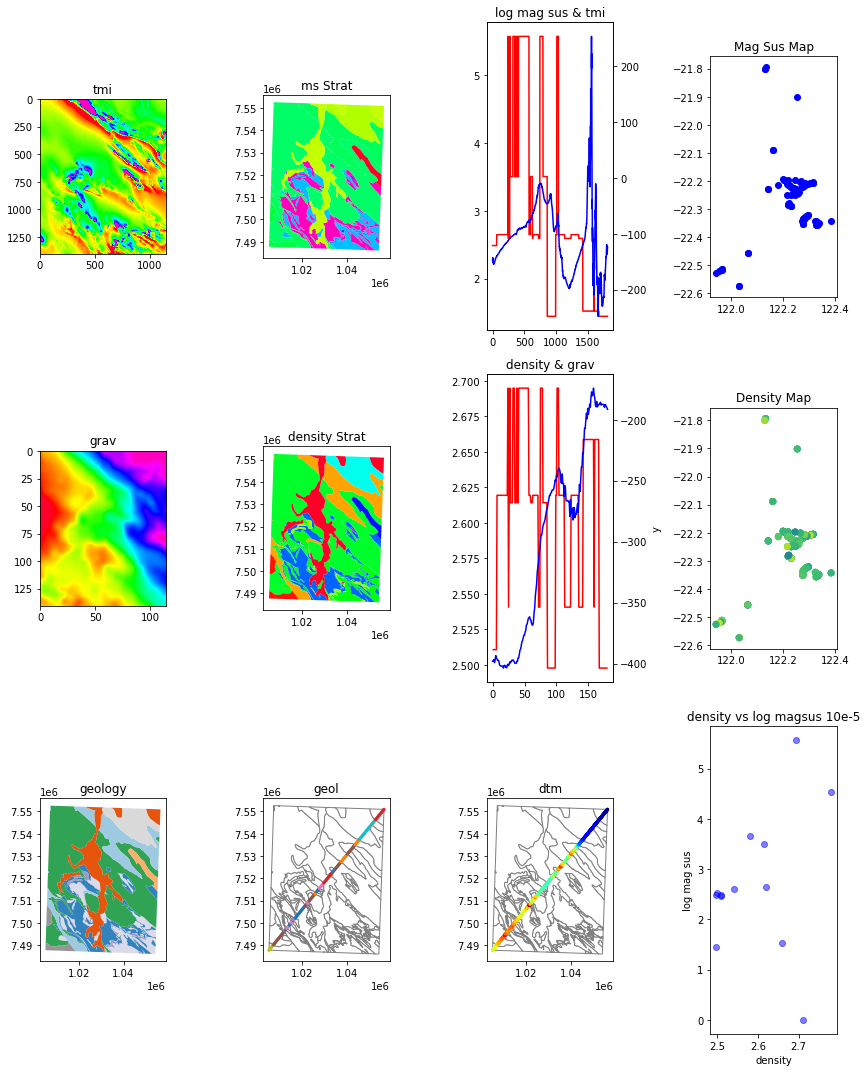

In [23]:

f, axes = plt.subplots(figsize=(12, 15), ncols=4, nrows=3,facecolor='white')


geophys.plot_grid(mag_data,axes[0][0],'tmi')
geophys.plot_petrophys_map(geol_clip,'ms',axes[0][1])
geophys.plot_profile(petro_profile_mag,mag_prof,'ms','log mag sus & tmi',axes[0][2])
geophys.plot_mag_sus(mag_sus,axes[0,3])

geophys.plot_grid(grav_data,axes[1][0],'grav')
geophys.plot_petrophys_map(geol_clip,'density',axes[1][1])
geophys.plot_profile(petro_profile_den,grav_prof,'density','density & grav',axes[1][2])
geophys.plot_density(density,axes[1,3])

geophys.plot_geol(geol_clip,'descriptn',axes[2,0])
geophys.plot_geol_profile(geol_clip,geol_code,axes[2][1])
geophys.plot_dtm_geol(dtm_profile,geol_clip,mag_long,mag_lat,axes[2][2])
geophys.plot_den_vs_ms(petrophysics,axes[2,3])

plt.tight_layout()
plt.savefig(root+'/summary_geophysics.png')

In [24]:
petro_profile_mag2=petro_profile_mag
ms_df=pd.DataFrame(zip(petro_profile_mag2.geometry.x,petro_profile_mag2.geometry.y,petro_profile_mag2.unitname,petro_profile_mag2.ms,[item for sublist in mag_prof for item in sublist]),columns =  ['x', 'y', 'unitname', 'magsus','mag'])
ms_df=ms_df[~ms_df.unitname.isna()]
ms_df.to_csv(root+'/profile_data_mag.csv')

petro_profile_den2=petro_profile_den
ms_df=pd.DataFrame(zip(petro_profile_den2.geometry.x,petro_profile_den2.geometry.y,petro_profile_den2.unitname,petro_profile_den2.density,[item for sublist in grav_prof for item in sublist]),columns =  ['x', 'y', 'unitname', 'density','grav'])
ms_df=ms_df[~ms_df.unitname.isna()]
ms_df.to_csv(root+'/profile_data_grav.csv')

geol_clip.to_file(root+'/geol_petro.shp')

/home/mark/anaconda3/envs/loop/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_10115/3994896695.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geol_clip.to_file(root+'/geol_petro.shp')
